This Note book is adapted from [WuJiaocan's Github](https://github.com/WuJiaocan/tensorflow)

In [0]:
import tensorflow as tf
import numpy as np

In [0]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [3]:
print(tf.__version__)

1.13.1


### 1.Get Test Data Set

In [0]:
src_path = 'en_clean.txt'
tgt_path = 'fr_clean.txt'

In [0]:
def read_data(txt_path, num_examples):
  text = []
  with open(txt_path, 'r', encoding="utf-8") as f:
    for line in f.readlines():
      line = line[7:-6]
      text.append(line.strip('\n'))
    return text[:num_examples]

In [0]:
src = read_data(src_path, 102000)
tgt = read_data(tgt_path, 102000)

In [0]:
src_test = src[101600:]
tgt_test = tgt[101600:]

In [10]:
len(tgt_test)
len(src_test)

400

### 2. Reload Vocab

In [0]:
def read_vocab(vocab_path):
  text = []
  with open(vocab_path, 'r', encoding="utf-8") as f:
    for line in f.readlines():
      text.append(line.strip('\n'))
    return text

In [0]:
vocab_src = read_vocab('vocab.en')
vocab_tgt = read_vocab('vocab.fr')

In [13]:
vocab_size_src = len(vocab_src)
vocab_size_tgt = len(vocab_tgt)

print('size of source vocab {}'.format(vocab_size_src))
print('size of target vocab {}'.format(vocab_size_tgt))

size of source vocab 40396
size of target vocab 49303


### 3.Define Model Structure, Hyper Parameter Used in Training, Inference Function

In [0]:
import tensorflow as tf
import codecs
import sys

In [0]:
# read checkpoint path, number indicates the latest step
CHECKPOINT_PATH = "ckpt-bahdanau-15600"

# Model HyperParameters, need to keep consistent with trained model
HIDDEN_SIZE = 256
DECODER_LAYERS = 2
SRC_VOCAB_SIZE = vocab_size_src
TRG_VOCAB_SIZE = vocab_size_tgt
SHARE_EMB_AND_SOFTMAX = True

# file for vocab
SRC_VOCAB = "vocab.en"
TRG_VOCAB = "vocab.fr"

# ID for <sos> and <eos> in vocab
SOS_ID = 1
EOS_ID = 2

In [0]:
class NMTModel(object):

    def __init__(self):
        # Define RNN CELL for Encoder and Decoder
        self.enc_cell_fw = tf.nn.rnn_cell.BasicLSTMCell(HIDDEN_SIZE)
        self.enc_cell_bw = tf.nn.rnn_cell.BasicLSTMCell(HIDDEN_SIZE)
        self.dec_cell = tf.nn.rnn_cell.MultiRNNCell(
          [tf.nn.rnn_cell.BasicLSTMCell(HIDDEN_SIZE) 
           for _ in range(DECODER_LAYERS)])

        # Define EMBEDDING LAYER for Source/Target Language
        self.src_embedding = tf.get_variable(
            "src_emb", [SRC_VOCAB_SIZE, HIDDEN_SIZE])
        self.trg_embedding = tf.get_variable(
            "trg_emb", [TRG_VOCAB_SIZE, HIDDEN_SIZE])

        # Define SOFTMAX LAYER (share with Embedding or not share)
        if SHARE_EMB_AND_SOFTMAX:
            self.softmax_weight = tf.transpose(self.trg_embedding)
        else:
            self.softmax_weight = tf.get_variable(
               "weight", [HIDDEN_SIZE, TRG_VOCAB_SIZE])
        self.softmax_bias = tf.get_variable(
            "softmax_bias", [TRG_VOCAB_SIZE])

    def inference(self, src_input):
        # As dynamic rnn requires batch input, 
        # to infer one single sentence, we set batch = 1
        src_size = tf.convert_to_tensor([len(src_input)], dtype=tf.int32)
        src_input = tf.convert_to_tensor([src_input], dtype=tf.int32)
        src_emb = tf.nn.embedding_lookup(self.src_embedding, src_input)

        with tf.variable_scope("encoder"):
            # Use bidirectional_dynamic_rnn for encoder as in training step
            enc_outputs, enc_state = tf.nn.bidirectional_dynamic_rnn(
                self.enc_cell_fw, self.enc_cell_bw, src_emb, src_size, 
                dtype=tf.float32)
            # concatenate two outputs of LSTM cell as 1 tensor
            # enc_outputs = (output_fw, output_bw)
            enc_outputs = tf.concat([enc_outputs[0], enc_outputs[1]], -1)    
        
        with tf.variable_scope("decoder"):
            # define ATTENTION MECHANISM for decoder
            attention_mechanism = tf.contrib.seq2seq.BahdanauAttention(
                HIDDEN_SIZE, enc_outputs,
                memory_sequence_length=src_size)

            # wrap decoder cell and attention mechanism as an ATTENTION CELL
            attention_cell = tf.contrib.seq2seq.AttentionWrapper(
                self.dec_cell, 
                attention_mechanism,
                attention_layer_size = HIDDEN_SIZE,
                alignment_history = True)
   
        # Set the max step for decoder
        MAX_DEC_LEN=100

        with tf.variable_scope("decoder/rnn/attention_wrapper"):
            # use TensorArray store produced sentence
            init_array = tf.TensorArray(dtype=tf.int32, size=0,
                dynamic_size=True, clear_after_read=False)
            # start input for decoder with <sos> tag
            init_array = init_array.write(0, SOS_ID)
            # initilize attention cell
            init_loop_var = (
                attention_cell.zero_state(batch_size=1, dtype=tf.float32),
                init_array, 0)

            # condition for tf.while_loop：
            # loop until decoder outputs <eos> or hit max length setting
            def continue_loop_condition(state, trg_ids, step):
                return tf.reduce_all(tf.logical_and(
                    tf.not_equal(trg_ids.read(step), EOS_ID),
                    tf.less(step, MAX_DEC_LEN-1)))

            def loop_body(state, trg_ids, step):
                # read last step output as input for attention cell
                trg_input = [trg_ids.read(step)]
                trg_emb = tf.nn.embedding_lookup(self.trg_embedding,
                                                 trg_input)
                # FORWARD calc ATTENTION CELL and output decoder outputs/state
                dec_outputs, next_state = attention_cell.call(
                    state=state, inputs=trg_emb)
       
                # calc logit for each candidate target vocab
                # select the max as output
                output = tf.reshape(dec_outputs, [-1, HIDDEN_SIZE])
                logits = (tf.matmul(output, self.softmax_weight)
                          + self.softmax_bias)
                next_id = tf.argmax(logits, axis=1, output_type=tf.int32)
                # write output word into trg_ids
                trg_ids = trg_ids.write(step+1, next_id[0])
                return next_state, trg_ids, step+1

            # execute tf.while_loop return trg_ides
            state, trg_ids, step = tf.while_loop(
                continue_loop_condition, loop_body, init_loop_var)
            return trg_ids.stack(), state

### 4. Test and Evaluate

In [0]:
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu

def levenshtein(seq1, seq2):  
    size_x = len(seq1) + 1
    size_y = len(seq2) + 1
    matrix = np.zeros ((size_x, size_y))
    for x in range(size_x):
        matrix [x, 0] = x
    for y in range(size_y):
        matrix [0, y] = y

    for x in range(1, size_x):
        for y in range(1, size_y):
            if seq1[x-1] == seq2[y-1]:
                matrix [x,y] = min(
                    matrix[x-1, y] + 1,
                    matrix[x-1, y-1],
                    matrix[x, y-1] + 1
                )
            else:
                matrix [x,y] = min(
                    matrix[x-1,y] + 1,
                    matrix[x-1,y-1] + 1,
                    matrix[x,y-1] + 1
                )

    return matrix[size_x - 1, size_y - 1]

def translate_en_fr(src_sent, trgt_sent, plot_att = False, verbose = False):
    
    tf.reset_default_graph()
        
    # define the trained model
    with tf.variable_scope("nmt_model", reuse=None):
        model = NMTModel()
       
    # convert sentence to word_index according to vocab
    with codecs.open(SRC_VOCAB, "r", "utf-8") as f_vocab:
        src_vocab = [w.strip() for w in f_vocab.readlines()]
        src_id_dict = dict((src_vocab[x], x) for x in range(len(src_vocab)))
    test_en_ids = [(src_id_dict[token] if token in src_id_dict else src_id_dict['<unk>'])
                   for token in src_sent.split()]

    # build inference based on saved model weights
    output_op, state_op = model.inference(test_en_ids)
    sess = tf.Session()
    saver = tf.train.Saver()
    saver.restore(sess, CHECKPOINT_PATH)

    # read translation output
    output_ids = sess.run(output_op)
    
    # convert translation idx into word
    with codecs.open(TRG_VOCAB, "r", "utf-8") as f_vocab:
        trg_vocab = [w.strip() for w in f_vocab.readlines()]
    output_text = ' '.join([trg_vocab[x] for x in output_ids])
    
    # output translation
    final_output_text = output_text.encode('utf8').decode(sys.stdout.encoding).strip('<eos>')
    
    bleu = sentence_bleu(trgt_sent.split(), final_output_text.split())
    lst = levenshtein(trgt_sent,final_output_text)
    
    if verbose:
      print("Source Sentence: " + src_sent)
      print("Real Translation: " + trgt_sent)
      print("Predicted Translation: " + final_output_text)
      print("Levenshetein Distance: " + str(lst))
      print("***BLEU Score***: "+ str(bleu))
    
    
    # PLOT ATTENTION PLOT OPTION
    
    def plot_attention(attention, src_sent, pred_sent):

      fig = plt.figure(figsize=(10,10))
      ax = fig.add_subplot(1, 1, 1)
      ax.matshow(attention, cmap='viridis')

      fontdict = {'fontsize': 14}
      
      ax.set_xticks(np.arange(len(list(src_sent.split()))))
      ax.set_yticks(np.arange(len(list(pred_sent.split()))))

      ax.set_xticklabels([''] + list(src_sent.split()), fontdict=fontdict, rotation=90)
      ax.set_yticklabels([''] + list(pred_sent.split()), fontdict=fontdict)

      plt.show()
      
    if plot_att:
      alignments = sess.run(state_op.alignment_history.stack())
      alignments = np.squeeze(alignments)
      plot_attention(alignments, src_sent, final_output_text)
      
    return final_output_text, bleu, lst
    
    sess.close()

In [0]:
# prediction for total test set

def test_set_pred(src_test, tgt_test, verbose = False):
  src_test = src_test
  tgt_test = tgt_test
 
  size = len(src_test)
  
  pred_list = []
  bleu_list = []
  lst_list = []

  for i in range(size):

      pred, bleu, lst = translate_en_fr(src_test[i], tgt_test[i], verbose = verbose)
      print("                                                                                         ")
      pred_list.append(pred)
      bleu_list.append(bleu)
      lst_list.append(lst)
      
      
  c_bleu = sum(bleu_list) / len(bleu_list)
  c_lst = sum(lst_list) / len(lst_list)  
   
  print("                                                                                         ")
  print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
  print("Prediction Output and Metrics on {} test sentences: ".format(size))
  print("Average BLEU Score on our test corpus is {}".format(c_bleu)) 
  print("Average Levenshetein distance Score on our test corpus is {}".format(c_lst)) 

### 5. Test

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use tf.cast instead.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ckpt-bahdanau-15600


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Source Sentence: comment on the misappropriation of bibliographical references in science . the example of anti aging medicine
Real Translation: du detournement des references bibliographiques en science . l exemple de la medecine anti age 
Predicted Translation:  du detournement financier de references en science . l exemple de la medecine anti age de medecins du age 
Levenshetein Distance: 44.0
***BLEU Score***: 0.5695988432761473


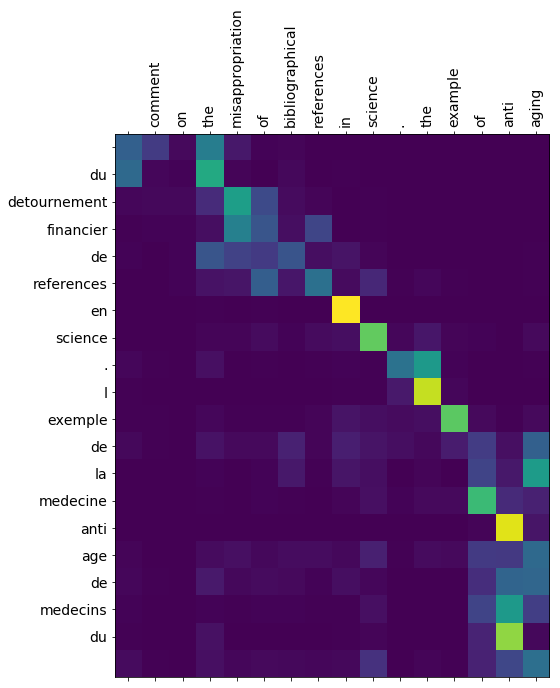

(' du detournement financier de references en science . l exemple de la medecine anti age de medecins du age ',
 0.5695988432761473,
 44.0)

In [19]:
src_sent = 'comment on the misappropriation of bibliographical references in science . the example of anti aging medicine'
tgt_sent = 'du detournement des references bibliographiques en science . l exemple de la medecine anti age '


translate_en_fr(src_sent,
                tgt_sent, 
                verbose = True,
                plot_att = True)

In [22]:
test_set_pred(src_test, tgt_test, verbose = True)

INFO:tensorflow:Restoring parameters from ckpt-bahdanau-15600


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Source Sentence:  shelf acetabuloplasty in legg perthes calve disease 
Real Translation:  la butee osteoplastique dans l osteochondrite primitive de la hanche 
Predicted Translation:  de la validite de la duree de test de heures dans la maladie de legg perthes resistant a l age de plus pronostique de la duree pronostique de la maladie c symptomatique polyvalente ou pronostique de mg de routine 
Levenshetein Distance: 167.0
***BLEU Score***: 0.5266403878479265
                                                                                         
INFO:tensorflow:Restoring parameters from ckpt-bahdanau-15600
Source Sentence:  failure of primary management of developmental dislocation of the hip years experience in normandy 
Real Translation:  echecs de la prise en charge initiale de la maladie luxante de la hanche en haute normandie analyse sur une periode de annees consecutives 
Predicted Translation:  echec de la prise en charge de la luxation congenitale de hanche operee de la hanch

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Source Sentence:  acute respiratory distress syndrome due to pneumonitis following intrathecal methotrexate administration 
Real Translation:  insuffisance respiratoire aigue avec pneumopathie apres administration intrathecale de methotrexate 
Predicted Translation:  syndrome de detresse respiratoire aigue par pneumopathie lors d une infection par methotrexate a l administration d methotrexate a methotrexate 
Levenshetein Distance: 71.0
***BLEU Score***: 0.32030896835479866
                                                                                         
INFO:tensorflow:Restoring parameters from ckpt-bahdanau-15600
Source Sentence:  bronchial anthracosis and pulmonary mica overload 
Real Translation:  anthracose bronchique et surcharge pulmonaire en micas 
Predicted Translation:  acute bronchiques nvpo des broncho pulmonaires en phase pulmonaire quot et des pneumologues 
Levenshetein Distance: 57.0
***BLEU Score***: 0
                                                            